# Composer Classification

In [18]:
# Import required libraries
import tensorflow as tf
import os
import numpy as np
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
# Define globals
data_directory = './/data'  #dataset path
fs = 5  # Sampling frequency for piano rolls

In [20]:
# Helper functions

In [21]:
# Function to load midi files, composer labels and compser map in seperate arrays

def load_midi_data_and_labels(directory):
    skipped_files = []    # Keep track of skipped files due to errors
    data = []
    composers = []
    num_composer_map = {}
    # Function to recursively iterate files in a directory
    def iterate_dir(dir_path, label, composer):        
        # Check direct .mid files in current directory
        for item in os.listdir(dir_path):
            item_path = os.path.join(dir_path, item)
            if os.path.isfile(item_path) and item_path.endswith('.mid'):
                try:
                    # Load the MIDI file
                    midi_data = pretty_midi.PrettyMIDI(item_path)
                    data.append(midi_data)
                    composers.append(label)                    
                except Exception as e:  # Catch any exception that might be raised
                    print(f"Skipping file {item_path} due to an error: {e}")
                    skipped_files.append(item_path)
            elif os.path.isdir(item_path):
                iterate_dir(item_path, label, composer)
        print(f"Number of files skipped due to error: {len(skipped_files)}")
        return

    # Process each composer's directory in the root directory
    for label, composer in enumerate(sorted(os.listdir(directory))):
        composer_path = os.path.join(directory, composer)
        if os.path.isdir(composer_path):
            num_composer_map[label] = composer
            iterate_dir(composer_path, label, composer)

    return np.array(data), np.array(composers), num_composer_map


In [22]:
midi_data, composer_labels, composer_map = load_midi_data_and_labels(data_directory)

Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Skipping file .//data\Beethoven\Anhang 14-3.mid due to an error: Could not decode key with 3 flats and mode 255
Number of files skipped due to error: 1
Number of files skipped due to error: 1
Number of files skipped due to error: 1
Number of files skipped due to error: 1
Number o

In [23]:
midi_data.shape

(1528,)

In [24]:
from IPython import display

# Define the sampling rate
_SAMPLING_RATE = 44100  # Standard audio sampling rate

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

display_audio(midi_data[0])

In [ ]:
def time_stretch_midi(data, stretching_factor):
    new_midi = copy_midi(data)
    for instrument in new_midi.instruments:
        for note in instrument.notes:
            note.start *= stretching_factor
            note.end *= stretching_factor
    return new_midi

In [50]:
import copy

def copy_midi(original_midi):
    # Create a deep copy of the original MIDI data
    copied_midi = copy.deepcopy(original_midi)
    return copied_midi

In [74]:
def augment_extend_composer_midi_files(composer_labels, composer_label, sample_percentage=0.25):
    # Find indices where composer_labels match the desired composer_label
    indices = np.where(composer_labels == composer_label)[0] 
    # Randomly select sample from these indices
    sampled_indices = np.random.choice(indices, len(indices), replace=False)    
    # take sample_percentage % of the sampled_indices
    sample_size = int(len(sampled_indices) * sample_percentage)   
    return sampled_indices[0:sample_size]


In [71]:
def augment_skip_composer_midi_files(composer_labels, composer_label, skip_percentage=0.50):
    # Find indices where composer_labels match the desired composer_label
    indices = np.where(composer_labels == label_bach)[0]  
    # Randomly select sample from these indices
    sampled_indices = np.random.choice(indices, len(indices), replace=False)
    sample_size = int(len(sampled_indices) * skip_percentage)
    skip_indices = sampled_indices[0:sample_size]  
    return skip_indices

In [72]:
# Augmentation - skip 50% of midi_files for Bach
skip_percentage = 0.50
label_bach = 0
data_reduced = []
labels_reduced = []
skip_indices = augment_skip_composer_midi_files(composer_labels, label_bach, skip_percentage)
# Remove elements at specified indices
data_reduced = np.delete(midi_data, skip_indices)
labels_reduced = np.delete(composer_labels, skip_indices)

In [82]:
composer_map

{0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Mozart'}

In [85]:
# Augmentation - create new 50% of midi_files for Beethoven, Chopin, and Mozart
data_extended = []
labels_extended = []

# Get the labels of composer for which midi_files need to be augmented
extend_midifiles_for = []
for key, value in composer_map.items():
        if value == 'Beethoven' or value == 'Chopin' or value == 'Mozart':
            extend_midifiles_for.append(key)

In [88]:
# Append the new midi files and labels in lists
for lable in extend_midifiles_for:
    composer_indices = augment_extend_composer_midi_files(composer_labels, lable, 0.5)
    print("Composer ", composer_map[lable], "sample size = ", len(composer_indices))
    for i in composer_indices:        
        stretched_midi = time_stretch_midi(midi_data[i], .5)
        data_extended.append(stretched_midi)
        labels_extended.append(lable)

Composer  Beethoven sample size =  105
Composer  Chopin sample size =  68
Composer  Mozart sample size =  128


In [81]:
display_audio(data_extended[0])

In [89]:
midi_data_augmented = []
composer_labels_augmented = []
midi_data_augmented = np.append(data_reduced, data_extended)
composer_labels_augmented = np.append(labels_reduced, labels_extended)

In [90]:
print(midi_data_augmented.shape)
print(len(composer_labels_augmented))

(1367,)
1367


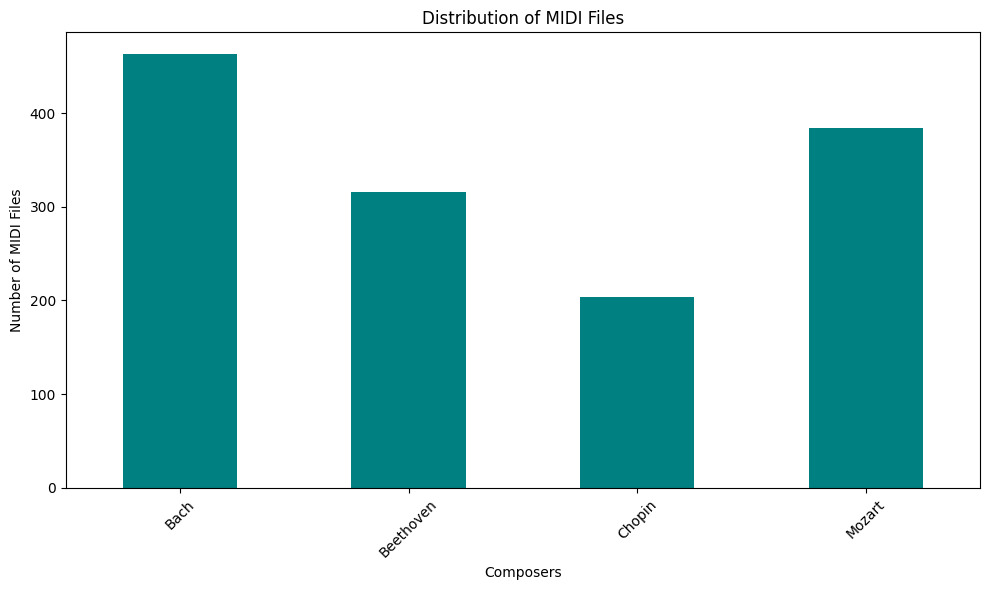

In [91]:
# Plot MIDI data distribution after augmentaion

# Convert list to pandas Series
composer_series = pd.Series(composer_labels_augmented)
# Count of each label
label_counts = composer_series.value_counts().sort_index()
# Map label counts to composer names
composer_counts = label_counts.rename(index=composer_map)
def plot_midi_distribution(composer_counts):
    # Plotting the data
    plt.figure(figsize=(10, 6))
    composer_counts.plot(kind='bar', color='teal')
    plt.xlabel('Composers')
    plt.ylabel('Number of MIDI Files')
    plt.title('Distribution of MIDI Files')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
    plt.show()

plot_midi_distribution(composer_counts)


## Data Pre-processing: 

Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI
files and applying data augmentation techniques.


## Feature Extraction: 

Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

### CNN Features

### LSTM 1 Features

### LSTM 2 Features

## Model Building: 

Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.

### CNN Architecture

### LSTM 1 Architecture

### LSTM 2 Architecture

## Model Training: 

Train the deep learning model using the pre-processed and feature-extracted data.

## Model Evaluation: 

Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.

## Model Optimization: 

Optimize the deep learning model by fine-tuning hyperparameters.